# STAC to GeoCroissant Conversion
<img src="../assets/GeoCroissant.jpg" alt="GeoCroissant" width="150" style="float: right; margin-left: 50px;">
This notebook converts metadata from a [STAC Collection](https://stacspec.org/en) into [GeoCroissant](https://github.com/mlcommons/croissant) JSON-LD format.

GeoCroissant is a geospatial extension of MLCommons' Croissant metadata standard. This enables ML-ready dataset descriptions including:

- Spatial extent (bounding box, geometry)
- Temporal coverage
- Data files (via `distribution`)
- Licensing, creators, and references

## STAC Collection to GeoCroissant Mapping
| STAC Field         | GeoCroissant Field       |
|--------------------|---------------------------|
| `title`            | `name`                   |
| `description`      | `description`            |
| `license`          | `license`                |
| `extent.spatial`   | `geocr:BoundingBox`      |
| `extent.temporal`  | `dct:temporal`           |
| `links`            | `references`             |
| `assets`           | `distribution`           |

## Import Required Libraries

In [1]:
!pip install mlcroissant pystac rasterio folium geopandas

## Load STAC Collection JSON
We load a `stac.json` file which conforms to the STAC Collection spec.
This function reads STAC fields and generates GeoCroissant metadata.

It includes handling for:
- Distribution files and MIME types
- Spatial and temporal coverage
- Title, license, creator info
- Unmapped STAC fields (for logging/debugging)

## Convert STAC to GeoCroissant Metadata
This function maps key STAC Collection fields into GeoCroissant JSON-LD format, using predefined field correspondences.
## Run the Conversion and Output GeoCroissant
Use the conversion function to transform the STAC JSON into GeoCroissant and save it as `croissant.json`.

In [2]:
import json
from datetime import datetime
import re


def sanitize_name(name):
    return re.sub(r"[^a-zA-Z0-9_\-]", "-", name)


def ensure_semver(version):
    if not version:
        return "1.0.0"
    if version.startswith("v"):
        version = version[1:]
    parts = version.split(".")
    if len(parts) == 2:
        parts.append("0")
    return ".".join(parts[:3])


def stac_to_geocroissant(stac_dict):
    dataset_id = stac_dict.get("id")
    name = sanitize_name(stac_dict.get("title", dataset_id or "UnnamedDataset"))
    version = ensure_semver(stac_dict.get("version", "1.0.0"))

    croissant = {
        "@context": {
            "@language": "en",
            "@vocab": "https://schema.org/",
            "citeAs": "cr:citeAs",
            "column": "cr:column",
            "conformsTo": "dct:conformsTo",
            "cr": "http://mlcommons.org/croissant/",
            "geocr": "http://mlcommons.org/croissant/geocr/",
            "rai": "http://mlcommons.org/croissant/RAI/",
            "dct": "http://purl.org/dc/terms/",
            "sc": "https://schema.org/",
            "data": {"@id": "cr:data", "@type": "@json"},
            "examples": {"@id": "cr:examples", "@type": "@json"},
            "dataBiases": "cr:dataBiases",
            "dataCollection": "cr:dataCollection",
            "dataType": {"@id": "cr:dataType", "@type": "@vocab"},
            "extract": "cr:extract",
            "field": "cr:field",
            "fileProperty": "cr:fileProperty",
            "fileObject": "cr:fileObject",
            "fileSet": "cr:fileSet",
            "format": "cr:format",
            "includes": "cr:includes",
            "isLiveDataset": "cr:isLiveDataset",
            "jsonPath": "cr:jsonPath",
            "key": "cr:key",
            "md5": "cr:md5",
            "parentField": "cr:parentField",
            "path": "cr:path",
            "personalSensitiveInformation": "cr:personalSensitiveInformation",
            "recordSet": "cr:recordSet",
            "references": "cr:references",
            "regex": "cr:regex",
            "repeated": "cr:repeated",
            "replace": "cr:replace",
            "samplingRate": "cr:samplingRate",
            "separator": "cr:separator",
            "source": "cr:source",
            "subField": "cr:subField",
            "transform": "cr:transform",
        },
        "@type": "sc:Dataset",
        "name": name,
        "description": stac_dict.get("description", ""),
        "conformsTo": "http://mlcommons.org/croissant/1.0",
        "version": version,
        "license": stac_dict.get("license", "CC-BY-4.0"),
    }

    # Add @id if available
    if dataset_id:
        croissant["@id"] = dataset_id

    if "sci:citation" in stac_dict:
        croissant["citeAs"] = stac_dict["sci:citation"]

    if stac_dict.get("providers"):
        provider = stac_dict["providers"][0]
        croissant["creator"] = {
            "@type": "Organization",
            "name": provider.get("name", "Unknown"),
            "url": provider.get("url", ""),
        }

    # Add keywords from summaries and other metadata
    keywords = []
    if "summaries" in stac_dict:
        summaries = stac_dict["summaries"]
        for key in ["mission", "platform", "instruments"]:
            if key in summaries:
                if isinstance(summaries[key], list):
                    keywords.extend(summaries[key])
                else:
                    keywords.append(summaries[key])

    # Add some basic geospatial keywords
    keywords.extend(["remote sensing", "geospatial", "satellite data"])

    if keywords:
        croissant["keywords"] = list(set(keywords))  # Remove duplicates

    # Handle 'self' URL
    for link in stac_dict.get("links", []):
        if link.get("rel") == "self":
            croissant["url"] = link.get("href")
            break

    # Handle other STAC references
    references = []
    for link in stac_dict.get("links", []):
        rel = link.get("rel")
        href = link.get("href")
        if not href or rel == "self":
            continue

        name_map = {
            "root": "STAC root catalog",
            "parent": "STAC parent catalog",
            "items": "STAC item list",
            "about": "GitHub Repository",
            "predecessor-version": "Previous version",
            "http://www.opengis.net/def/rel/ogc/1.0/queryables": "Queryables",
        }

        references.append(
            {
                "@type": "CreativeWork",
                "url": href,
                "name": name_map.get(rel, rel),
                "encodingFormat": link.get("type", "application/json"),
            }
        )

    if references:
        croissant["references"] = references

    # Spatial and temporal extent
    spatial = stac_dict.get("extent", {}).get("spatial", {}).get("bbox")
    if spatial:
        croissant["geocr:BoundingBox"] = spatial[0]

    temporal = stac_dict.get("extent", {}).get("temporal", {}).get("interval")
    if temporal and temporal[0]:
        start, end = temporal[0][0], temporal[0][1]
        croissant["geocr:temporalExtent"] = {"startDate": start, "endDate": end}
        croissant["datePublished"] = start
    else:
        croissant["datePublished"] = datetime.utcnow().isoformat() + "Z"

    # Add geospatial metadata
    if "summaries" in stac_dict:
        summaries = stac_dict["summaries"]
        if "gsd" in summaries:
            gsd = summaries["gsd"]
            if isinstance(gsd, dict):
                resolution = f"{gsd.get('minimum', gsd.get('maximum', 30))}m"
            elif isinstance(gsd, list):
                resolution = f"{gsd[0]}m"
            else:
                resolution = f"{gsd}m"
            croissant["geocr:spatialResolution"] = resolution

    croissant["geocr:coordinateReferenceSystem"] = "EPSG:4326"

    # Distribution section with FileObjects and FileSets
    croissant["distribution"] = []

    # Add collection-level assets as FileObjects
    for key, asset in stac_dict.get("assets", {}).items():
        file_object = {
            "@type": "cr:FileObject",
            "@id": key,
            "name": key,
            "description": asset.get("description", asset.get("title", "")),
            "contentUrl": asset.get("href"),
            "encodingFormat": asset.get("type", "application/octet-stream"),
        }

        # Handle checksums
        if "checksum:multihash" in asset:
            file_object["sha256"] = asset["checksum:multihash"]
        elif "file:checksum" in asset:
            file_object["sha256"] = asset["file:checksum"]
        else:
            file_object["sha256"] = "placeholder_hash"

        if "checksum:md5" in asset:
            file_object["md5"] = asset["checksum:md5"]
        else:
            file_object["md5"] = "placeholder_hash"

        croissant["distribution"].append(file_object)

    # Add item_assets as FileSet for data files
    if "item_assets" in stac_dict:
        # Create a FileSet for the item assets
        main_fileset = {
            "@type": "cr:FileSet",
            "@id": f"{dataset_id}-files" if dataset_id else "dataset-files",
            "name": f"{dataset_id} data files" if dataset_id else "Dataset data files",
            "description": "Collection of data files for this dataset",
            "encodingFormat": "application/octet-stream",
        }

        # If there are multiple item assets, we could include them all
        # For now, we'll create a generic pattern
        if stac_dict["item_assets"]:
            first_asset = list(stac_dict["item_assets"].values())[0]
            main_fileset["encodingFormat"] = first_asset.get(
                "type", "application/octet-stream"
            )
            main_fileset["includes"] = "**/*"  # Generic pattern

        croissant["distribution"].append(main_fileset)

    # Add basic recordSet structure for data access
    if "item_assets" in stac_dict and stac_dict["item_assets"]:
        croissant["recordSet"] = []

        # Create a basic recordSet for data splits/files
        record_set = {
            "@type": "cr:RecordSet",
            "@id": f"{dataset_id}_records" if dataset_id else "dataset_records",
            "name": (
                f"{dataset_id} data records" if dataset_id else "Dataset data records"
            ),
            "description": "Data records for this dataset",
            "field": [],
        }

        # Add fields for each item asset
        for asset_key, asset_info in stac_dict["item_assets"].items():
            # Determine proper dataType based on asset type
            asset_type = asset_info.get("type", "")
            if "image" in asset_type or "tiff" in asset_type:
                data_type = "sc:ImageObject"
            elif "csv" in asset_type or "text" in asset_type:
                data_type = "sc:Text"
            else:
                data_type = "sc:Text"  # Default fallback

            field = {
                "@type": "cr:Field",
                "@id": f"data/{asset_key}",
                "name": f"data/{asset_key}",
                "description": asset_info.get(
                    "description", asset_info.get("title", f"{asset_key} data")
                ),
                "dataType": data_type,
                "source": {
                    "fileSet": {
                        "@id": f"{dataset_id}-files" if dataset_id else "dataset-files"
                    },
                    "extract": {"fileProperty": "fullpath"},
                    "transform": {"regex": f".*{asset_key}.*"},
                },
            }

            # Add geospatial information if available
            if "bands" in asset_info:
                bands = asset_info["bands"]
                if isinstance(bands, list) and len(bands) > 0:
                    if isinstance(bands[0], dict) and "data_type" in bands[0]:
                        field["geocr:dataType"] = bands[0]["data_type"]

            record_set["field"].append(field)

        croissant["recordSet"].append(record_set)

    if "renders" in stac_dict:
        croissant["geocr:visualizations"] = stac_dict["renders"]

    if "summaries" in stac_dict:
        croissant["geocr:summaries"] = stac_dict["summaries"]

    if "stac_extensions" in stac_dict:
        croissant["geocr:stac_extensions"] = stac_dict["stac_extensions"]
    if "stac_version" in stac_dict:
        croissant["geocr:stac_version"] = stac_dict["stac_version"]

    if "deprecated" in stac_dict:
        croissant["isLiveDataset"] = not stac_dict["deprecated"]

    # Report unmapped fields
    mapped_keys = {
        "id",
        "type",
        "links",
        "title",
        "assets",
        "extent",
        "license",
        "version",
        "providers",
        "description",
        "sci:citation",
        "renders",
        "summaries",
        "stac_extensions",
        "stac_version",
        "deprecated",
        "item_assets",
    }
    extra_fields = {k: v for k, v in stac_dict.items() if k not in mapped_keys}
    print("\n\033[1mUnmapped STAC Fields:\033[0m")
    if extra_fields:
        for k, v in extra_fields.items():
            print(f"- {k}: {type(v).__name__}")
    else:
        print("None ")

    return croissant


# === Main Runner ===
if __name__ == "__main__":
    # Load STAC Collection JSON
    with open("stac.json") as f:
        stac_data = json.load(f)

    # Convert to GeoCroissant
    croissant_json = stac_to_geocroissant(stac_data)

    # Save GeoCroissant JSON-LD
    with open("croissant.json", "w") as f:
        json.dump(croissant_json, f, indent=2)

    print("\nGeoCroissant conversion complete. Output saved to 'croissant.json'")


Unmapped STAC Fields:
None 

GeoCroissant conversion complete. Output saved to 'croissant.json'


## Preview croissant.json
Use this cell to inspect the structure and values of the converted metadata.

In [3]:
import json

# Load and pretty-print the content of croissant.json
with open("croissant.json", "r") as f:
    croissant_data = json.load(f)

# Pretty-print JSON to console
print(json.dumps(croissant_data, indent=2))

{
  "@context": {
    "@language": "en",
    "@vocab": "https://schema.org/",
    "citeAs": "cr:citeAs",
    "column": "cr:column",
    "conformsTo": "dct:conformsTo",
    "cr": "http://mlcommons.org/croissant/",
    "geocr": "http://mlcommons.org/croissant/geocr/",
    "rai": "http://mlcommons.org/croissant/RAI/",
    "dct": "http://purl.org/dc/terms/",
    "sc": "https://schema.org/",
    "data": {
      "@id": "cr:data",
      "@type": "@json"
    },
    "examples": {
      "@id": "cr:examples",
      "@type": "@json"
    },
    "dataBiases": "cr:dataBiases",
    "dataCollection": "cr:dataCollection",
    "dataType": {
      "@id": "cr:dataType",
      "@type": "@vocab"
    },
    "extract": "cr:extract",
    "field": "cr:field",
    "fileProperty": "cr:fileProperty",
    "fileObject": "cr:fileObject",
    "fileSet": "cr:fileSet",
    "format": "cr:format",
    "includes": "cr:includes",
    "isLiveDataset": "cr:isLiveDataset",
    "jsonPath": "cr:jsonPath",
    "key": "cr:key",
   

# Validate with mlcroissant
We use the `mlcroissant` CLI to validate the structure of the generated JSON-LD.
```bash
!mlcroissant validate --jsonld=croissant.json
```

In [4]:
!mlcroissant validate --jsonld=croissant.json

I0902 15:13:53.569391 127435963113856 validate.py:53] Done.


In [5]:
import rasterio
import json
import numpy as np

# URL of the COG file via /vsicurl
cog_url = "/vsicurl/https://nasa-maap-data-store.s3.amazonaws.com/file-staging/nasa-map/icesat2-boreal-v2.1/agb/0039261/boreal_agb_2020_202501211737487322_0039261.tif"

with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    with rasterio.open(cog_url) as src:
        # ---- Print metadata (JSON safe) ----
        meta = src.meta.copy()
        if "crs" in meta and meta["crs"] is not None:
            meta["crs"] = meta["crs"].to_string()

        print("Metadata:")
        print(json.dumps(meta, indent=2))

        # ---- Print image summary ----
        print(f"\nCRS: {src.crs}")
        print(f"Shape: {src.width}x{src.height}, Bands: {src.count}")

        for i in range(1, src.count + 1):
            band = src.read(i, masked=True)  # Returns a MaskedArray
            mask = band.mask
            data = band.data

            total_pixels = band.size
            valid_pixels = np.count_nonzero(~mask)
            nan_pixels = np.count_nonzero(mask)

            print(f"\nBand {i} Stats:")
            print(f"  - Shape         : {band.shape}")
            print(f"  - Total pixels  : {total_pixels}")
            print(f"  - Valid pixels  : {valid_pixels}")
            print(f"  - NaNs (masked) : {nan_pixels}")

            if valid_pixels > 0:
                print(f"  - Min           : {data[~mask].min():.6f}")
                print(f"  - Max           : {data[~mask].max():.6f}")
                print(f"  - Mean          : {data[~mask].mean():.6f}")
            else:
                print("No valid data in this band.")

Metadata:
{
  "driver": "GTiff",
  "dtype": "float32",
  "nodata": NaN,
  "width": 3000,
  "height": 3000,
  "count": 2,
  "crs": "PROJCS[\"unnamed\",GEOGCS[\"GRS 1980(IUGG, 1980)\",DATUM[\"unknown\",SPHEROID[\"GRS80\",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM[\"Greenwich\",0],UNIT[\"degree\",0.0174532925199433,AUTHORITY[\"EPSG\",\"9122\"]]],PROJECTION[\"Albers_Conic_Equal_Area\"],PARAMETER[\"latitude_of_center\",40],PARAMETER[\"longitude_of_center\",180],PARAMETER[\"standard_parallel_1\",50],PARAMETER[\"standard_parallel_2\",70],PARAMETER[\"false_easting\",0],PARAMETER[\"false_northing\",0],UNIT[\"metre\",1,AUTHORITY[\"EPSG\",\"9001\"]],AXIS[\"Easting\",EAST],AXIS[\"Northing\",NORTH]]",
  "transform": [
    30.0,
    0.0,
    2078521.9999999953,
    0.0,
    -30.0,
    4383304.000000009,
    0.0,
    0.0,
    1.0
  ]
}

CRS: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],U

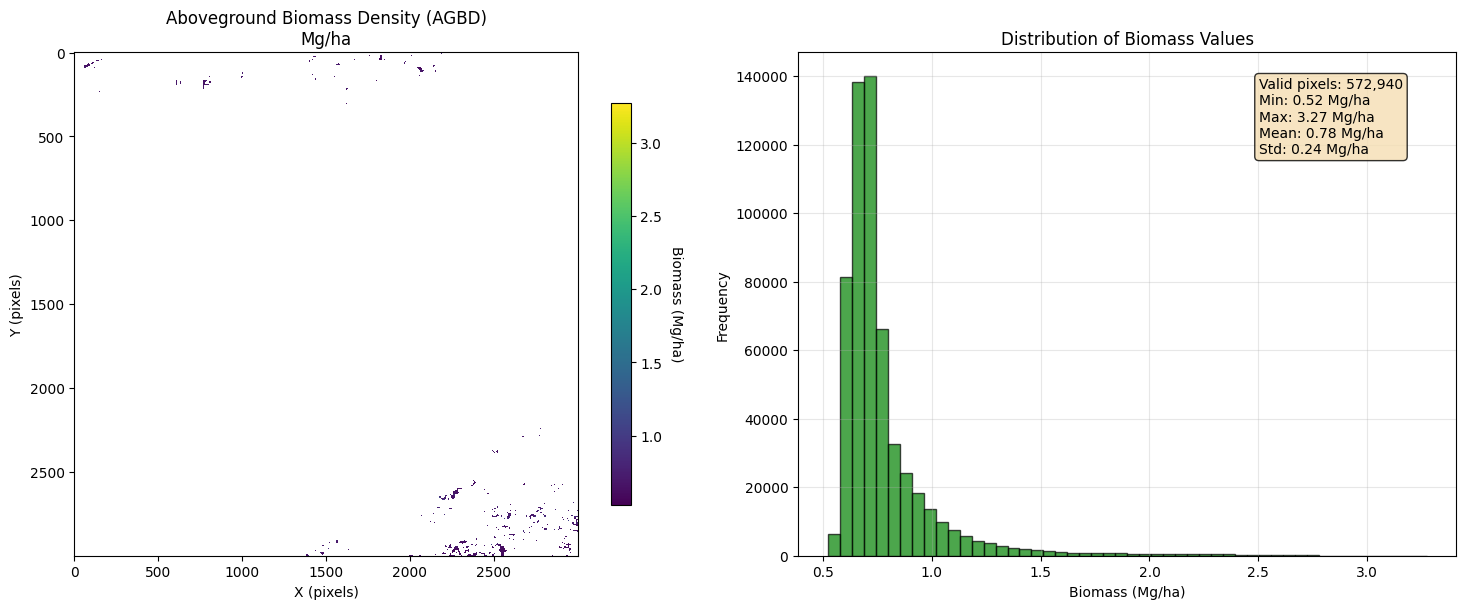

Dataset Info:
  - CRS: PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
  - Bounds: BoundingBox(left=2078521.9999999953, bottom=4293304.000000009, right=2168521.9999999953, top=4383304.000000009)
  - Resolution: 30.0m x 30.0m
  - Total pixels: 9,000,000
  - Valid pixels: 572,940 (6.4%)


In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import warnings

warnings.filterwarnings("ignore")

# COG URL for biomass data
cog_url = "https://nasa-maap-data-store.s3.amazonaws.com/file-staging/nasa-map/icesat2-boreal-v2.1/agb/0039261/boreal_agb_2020_202501211737487322_0039261.tif"

# Open the raster and create visualization
with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    with rasterio.open(cog_url) as src:
        # Read the first band (biomass data)
        biomass_data = src.read(1, masked=True)

        # Create figure with subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Plot 1: Raw biomass data
        im1 = ax1.imshow(biomass_data, cmap="viridis", aspect="equal")
        ax1.set_title("Aboveground Biomass Density (AGBD)\nMg/ha", fontsize=12)
        ax1.set_xlabel("X (pixels)")
        ax1.set_ylabel("Y (pixels)")

        # Add colorbar
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
        cbar1.set_label("Biomass (Mg/ha)", rotation=270, labelpad=15)

        # Plot 2: Histogram of biomass values
        valid_data = biomass_data[~biomass_data.mask]
        ax2.hist(valid_data, bins=50, alpha=0.7, color="green", edgecolor="black")
        ax2.set_title("Distribution of Biomass Values", fontsize=12)
        ax2.set_xlabel("Biomass (Mg/ha)")
        ax2.set_ylabel("Frequency")
        ax2.grid(True, alpha=0.3)

        # Add statistics text
        stats_text = f"Valid pixels: {len(valid_data):,}\n"
        stats_text += f"Min: {valid_data.min():.2f} Mg/ha\n"
        stats_text += f"Max: {valid_data.max():.2f} Mg/ha\n"
        stats_text += f"Mean: {valid_data.mean():.2f} Mg/ha\n"
        stats_text += f"Std: {valid_data.std():.2f} Mg/ha"

        ax2.text(
            0.7,
            0.95,
            stats_text,
            transform=ax2.transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
        )

        plt.tight_layout()
        plt.show()

        # Print basic info
        print(f"Dataset Info:")
        print(f"  - CRS: {src.crs}")
        print(f"  - Bounds: {src.bounds}")
        print(f"  - Resolution: {src.res[0]:.1f}m x {src.res[1]:.1f}m")
        print(f"  - Total pixels: {src.width * src.height:,}")
        print(
            "  - Valid pixels:"
            f" {len(valid_data):,} ({len(valid_data)/(src.width * src.height)*100:.1f}%)"
        )